# Image Compression using Autoencoders with BPSK

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* joint compression and error protection of images by auto-encoders
* generation of BPSK symbols using stochastic quantizers
* transmission over a binary symmetric channel (BSC)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


### Import and load MNIST dataset (Preprocessing)
Dataloader are powerful instruments, which help you to prepare your data. E.g. you can shuffle your data, transform data (standardize/normalize), divide it into batches, ...  For more information see https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader <br>

In our case, we just use the dataloader to download the Dataset and preprocess the data on our own.

In [6]:
batch_size_train = 60000      # Samples per Training Batch
batch_size_test = 10000     # just create one large test dataset (MNIST test dataset has 10.000 Samples)

# Get Training and Test Dataset with a Dataloader
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
  transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
  transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])),
  batch_size=batch_size_test, shuffle=True)

# We are only interessted in the data and not in the targets
for idx, (data, targets) in enumerate(train_loader):
    x_train = data[:,0,:,:]

for idx, (data, targets) in enumerate(test_loader):
    x_test = data[:,0,:,:]

image_size = x_train.shape[1]
x_test_flat = torch.reshape(x_test, (x_test.shape[0], image_size*image_size))

Plot 8 random images

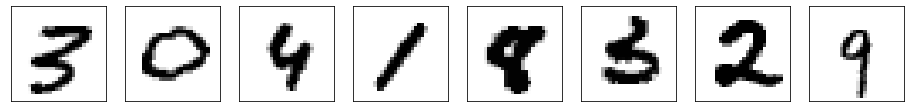

In [7]:
plt.figure(figsize=(16,2))
for k in range(8):
    plt.subplot(1,8,k+1)
    plt.imshow(x_train[np.random.randint(x_train.shape[0])], interpolation='nearest', cmap='binary')
    plt.xticks(())
    plt.yticks(())

### Specify Autoencoder
As explained in the lecture, we are using Stochstic Quantization. This means for the training process (*def forward*), we employ stochastic quantization in forward path but during back-propagation, we consider the quantization device as being
non-existent (*.detach()*). While validating and testing, use deterministic quantization (*def test*) <br>


*Note: .detach() removes the tensor from the computation graph*

In [8]:
hidden_encoder_1 = 500
hidden_encoder_2 = 250
hidden_encoder_3 = 100
hidden_encoder = [hidden_encoder_1, hidden_encoder_2, hidden_encoder_3]

hidden_decoder_1 = 100
hidden_decoder_2 = 250
hidden_decoder_3 = 500
hidden_decoder = [hidden_decoder_1, hidden_decoder_2, hidden_decoder_3]


class Autoencoder(nn.Module):
    def __init__(self, hidden_encoder, hidden_decoder, image_size, bit_per_image):
        super(Autoencoder, self).__init__()
       
        # Define Transmitter Layer: Linear function, M input neurons (symbols), 2 output neurons (real and imaginary part)        
        self.We1 = nn.Linear(image_size*image_size, hidden_encoder[0]) 
        self.We2 = nn.Linear(hidden_encoder[0], hidden_encoder[1]) 
        self.We3 = nn.Linear(hidden_encoder[1], hidden_encoder[2]) 
        self.We4 = nn.Linear(hidden_encoder[2], bit_per_image)         
        
        # Define Receiver Layer: Linear function, 2 input neurons (real and imaginary part), M output neurons (symbols)
        self.Wd1 = nn.Linear(bit_per_image,hidden_decoder[0]) 
        self.Wd2 = nn.Linear(hidden_decoder[0], hidden_decoder[1]) 
        self.Wd3 = nn.Linear(hidden_decoder[1], hidden_decoder[2]) 
        self.Wd4 = nn.Linear(hidden_decoder[2], image_size*image_size) 

        # Non-linearity (used in transmitter and receiver)
        self.activation_function = nn.ELU()    
        self.sigmoid = nn.Sigmoid()
        self.softsign = nn.Softsign()
        
    def forward(self, training_data, Pe):
        encoded = self.encoder(training_data)
        # random binarization in training
        ti = encoded.clone()
        compressed = ti + (self.binarizer(ti) - ti).detach()
        # add error pattern (flip the bit or not)
        error_tensor = torch.distributions.Bernoulli(Pe * torch.ones_like(compressed)).sample() 
        received = torch.mul( compressed, 1 - 2*error_tensor)
        
        reconstructed = self.decoder(received)
        return reconstructed
        
    def test(self, valid_data, Pe):
        encoded_test = self.encoder(valid_data)
        compressed_test = self.binarizer(encoded_test)
        error_tensor_test = torch.distributions.Bernoulli(Pe * torch.ones_like(compressed_test)).sample()
        received_test = torch.mul( compressed_test, 1 - 2*error_tensor_test )
        reconstructed_test = self.decoder(received_test)
        loss_test = torch.mean(torch.square(valid_data - reconstructed_test))

        reconstructed_test_noerror = self.decoder(compressed_test)
        return reconstructed_test
        
    def encoder(self, batch):
        temp = self.activation_function(self.We1(batch))
        temp = self.activation_function(self.We2(temp))
        temp = self.activation_function(self.We3(temp))
        output = self.softsign(self.We4(temp))
        return output
    
    def decoder(self, batch):
        temp = self.activation_function(self.Wd1(batch))
        temp = self.activation_function(self.Wd2(temp))
        temp = self.activation_function(self.Wd3(temp))
        output = self.sigmoid(self.Wd4(temp))
        return output
    
    def binarizer(self, input):
        # This is the stochastic quatizer which we use for the training
        return torch.sign(input)

Helper function to get a random mini-batch of images

In [9]:
def get_batch(x, batch_size):
    idxs = np.random.randint(0, x.shape[0], (batch_size))
    return torch.stack([torch.reshape(x[k], (-1,)) for k in idxs])

### Perform the training

In [ ]:
batch_size = 250
Pe_range = np.array([0, 0.01, 0.1, 0.2])
bit_range = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 100])

SNR_result = np.zeros( (len(Pe_range), len(bit_range)) )

# Mean Squared Error loss
loss_fn = nn.MSELoss()



for i in range(len(Pe_range)):
    for j in range(len(bit_range)):
        best_SNR = -9999;
        print('Initializing ....')
        
        model = Autoencoder(hidden_encoder, hidden_decoder, image_size, bit_range[j])
        model.to(device)


        # Adam Optimizer
        optimizer = optim.Adam(model.parameters())    
    
        print('Start Training')   # Training loop

        for it in range(100000):  # Original paper does 50k iterations  
            mini_batch = torch.Tensor(get_batch(x_train, batch_size)).to(device)
            # Propagate (training) data through the net
            reconstructed = model(mini_batch, Pe_range[i])
    
            # compute loss
            loss = loss_fn(mini_batch, reconstructed)

            # compute gradients
            loss.backward()

            # Adapt weights
            optimizer.step()

            # reset gradients
            optimizer.zero_grad()
    
            # Evaulation with the test data
            if it % 500 == 0:
                reconstructed_test = model.test(x_test_flat.to(device), Pe_range[i])
                noise =  torch.mean(torch.square(x_test_flat.to(device) - reconstructed_test))
                SNR = 10.0 * (torch.log(torch.mean(torch.square(x_test_flat.to(device)))) - torch.log(noise)) / np.log(10.0)                
                cur_SNR = SNR.detach().cpu().numpy().squeeze()
                if cur_SNR > best_SNR:
                    best_SNR = cur_SNR
                    
            if it % 10000 == 0:            
                print('Pe = %1.2f, bits = %d, It %d: (best SNR: %1.4f dB)' % (Pe_range[i], bit_range[j], it, best_SNR))
        
        SNR_result[i,j] = best_SNR
        print('Finished learning for e = %1.2f, bits = %d. Best SNR: %1.4f' % (Pe_range[i], bit_range[j], best_SNR))
    
print('Training finished')
np.savetxt('SNR_result_simple.txt', SNR_result, delimiter=',')

Initializing ....
Start Training
Pe = 0.00, bits = 5, It 0: (best SNR: -2.8655 dB)
Pe = 0.00, bits = 5, It 10000: (best SNR: 3.7106 dB)
Pe = 0.00, bits = 5, It 20000: (best SNR: 3.7488 dB)
